In [1]:
# Uncomment and run these lines if you're in a fresh environment
# !pip install pythainlp
# !pip install sklearn
# !pip install torch torchvision torchaudio
# !pip install tqdm
# !pip install matplotlib seaborn
# !pip install tensorflow  # Keras Tokenizer

import numpy as np
import pandas as pd
import pickle
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Thai language processing
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords

# For progress bar
from tqdm import tqdm

# Keras Tokenizer and pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
def clean_text(text):
    """Clean and normalize text."""
    if isinstance(text, list):
        text = ' '.join(map(str, text))
    elif pd.isna(text):
        text = ''
    else:
        text = str(text)
    return text

def process_thai_text(text):
    """Process Thai text with specific handling."""
    # Clean the text first
    text = clean_text(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters but keep Thai characters and English letters
    text = re.sub(r'[^\u0E00-\u0E7Fa-zA-Z\s]', '', text)

    try:
        # Tokenize using Thai word tokenizer
        words = word_tokenize(text, engine="newmm")

        # Remove Thai stopwords and short words
        stop_words_thai = set(thai_stopwords())
        words = [w for w in words if w not in stop_words_thai and len(w) > 1]

        return ' '.join(words)
    except:
        # Fallback to simple space splitting if Thai tokenization fails
        return ' '.join(text.split())

def augment_thai_text(text, p=0.3):
    """Augment Thai text for the 'Fake News' class."""
    text = clean_text(text)

    try:
        words = word_tokenize(text, engine="newmm")

        # Randomly drop some words
        if random.random() < p and len(words) > 5:
            words = random.sample(words, int(len(words) * 0.8))

        # Randomly shuffle pairs of words
        if random.random() < p and len(words) > 5:
            for i in range(0, len(words)-2, 2):
                if random.random() < 0.5:
                    words[i], words[i+1] = words[i+1], words[i]
    except:
        words = text.split()

    return ' '.join(words)

def add_engineered_features(text):
    """Extract additional features from text."""
    text = clean_text(text)
    features = []

    # Ratio of Thai characters to total length
    thai_chars = len(re.findall(r'[\u0E00-\u0E7F]', text))
    features.append(thai_chars / (len(text) + 1))  # Add 1 to avoid division by zero

    # Number of URLs
    urls = len(re.findall(r'http\S+|www\S+|https\S+', text))
    features.append(urls)

    # Text length
    features.append(len(text))

    # Number of Thai words
    try:
        thai_words = len([w for w in word_tokenize(text, engine="newmm")
                          if re.match(r'[\u0E00-\u0E7F]+', w)])
    except:
        thai_words = 0
    features.append(thai_words)

    return features


In [3]:
def load_and_preprocess_data(filepath):
    print("Loading data...")
    df = pd.read_json(filepath, lines=True)
    print("Initial dataset shape:", df.shape)

    # Clean and combine text data
    df['Title'] = df['Title'].apply(clean_text)
    df['Detail'] = df['Detail'].apply(clean_text)
    df['text'] = df['Title'] + ' ' + df['Detail']

    # Create label mapping for Fake News (1) vs Fact News (0)
    label_mapping = {"Fake News": 1.0, "Fact News": 0.0}
    df["label"] = df["Document Tag"].map(label_mapping)

    # Keep only Fake News and Fact News
    df = df[df['Document Tag'].isin(['Fake News', 'Fact News'])]
    print("Dataset shape after filtering:", df.shape)

    print("\nLabel distribution after cleaning:")
    print(df["label"].value_counts())
    print("\nLabel distribution (proportions):")
    print(df["label"].value_counts(normalize=True))

    # Process text and create engineered features
    df["cleaned_text"] = df["text"].apply(process_thai_text)
    df["engineered_features"] = df["text"].apply(add_engineered_features)

    return df

def augment_data(df):
    print("\nAugmenting data for Fake News class...")
    augmented_texts = []
    augmented_eng_features = []
    augmented_labels = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        text_str = str(row['cleaned_text'])
        eng = row['engineered_features']
        label = row['label']

        # Original data
        augmented_texts.append(text_str)
        augmented_eng_features.append(eng)
        augmented_labels.append(label)

        # Add augmented version for fake news class
        if label == 1:
            aug_text = augment_thai_text(text_str)
            augmented_texts.append(aug_text)
            augmented_eng_features.append(eng)
            augmented_labels.append(label)

    # Create augmented DataFrame
    augmented_df = pd.DataFrame({
        'cleaned_text': augmented_texts,
        'engineered_features': augmented_eng_features,
        'label': augmented_labels
    })

    print(f"Training set size after augmentation: {augmented_df.shape[0]}")
    return augmented_df

def tokenize_and_pad(train_texts, test_texts, maxlen=200):
    print("\nTokenizing text...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_texts)

    X_train_seq = tokenizer.texts_to_sequences(train_texts)
    X_test_seq = tokenizer.texts_to_sequences(test_texts)

    vocab_size = len(tokenizer.word_index)
    print(f"Vocabulary size: {vocab_size}")

    # Pad sequences
    X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding="post")
    X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding="post")

    return X_train_pad, X_test_pad, tokenizer, vocab_size


In [4]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, eng_features, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        
        # Convert list of lists to numpy array, then to tensor
        eng_features = np.array(eng_features)
        self.eng_features = torch.tensor(eng_features, dtype=torch.float)
        
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.eng_features[idx], self.labels[idx]

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch_size, seq_len, hidden_dim]
        e = torch.tanh(self.attention(x))  # [batch_size, seq_len, 1]
        a = torch.softmax(e, dim=1)        # [batch_size, seq_len, 1]
        output = x * a                     # [batch_size, seq_len, hidden_dim]
        output = torch.sum(output, dim=1)  # [batch_size, hidden_dim]
        return output

class FakeNewsModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_eng_features):
        super(FakeNewsModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(0.3)

        self.bilstm1 = nn.LSTM(embedding_dim, 256, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(512, 128, batch_first=True, bidirectional=True)

        # Attention (input is bilstm2 output -> hidden_dim=128*2=256)
        self.attention = AttentionLayer(256)

        self.eng_dense = nn.Sequential(
            nn.Linear(n_eng_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )

        self.combined_dense = nn.Sequential(
            nn.Linear(256 + 32, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 2)  # Output layer (logits for 2 classes)
        )

    def forward(self, text, eng):
        x = self.embedding(text)        # [batch_size, maxlen, embedding_dim]
        x = self.dropout(x)

        x, _ = self.bilstm1(x)         # [batch_size, maxlen, 512]
        x = self.dropout(x)

        x, _ = self.bilstm2(x)         # [batch_size, maxlen, 256]
        x = self.dropout(x)

        context = self.attention(x)    # [batch_size, 256]

        eng_features = self.eng_dense(eng)  # [batch_size, 32]
        combined = torch.cat((context, eng_features), dim=1)  # [batch_size, 288]

        out = self.combined_dense(combined)  # [batch_size, 2]
        return out


In [5]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_correct = 0

    for texts, eng, labels in tqdm(dataloader, desc="Training", leave=False):
        texts = texts.to(device)
        eng = eng.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts, eng)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * texts.size(0)
        _, preds = torch.max(outputs, 1)
        epoch_correct += (preds == labels).sum().item()

    return epoch_loss / len(dataloader.dataset), epoch_correct / len(dataloader.dataset)

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_correct = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, eng, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            texts = texts.to(device)
            eng = eng.to(device)
            labels = labels.to(device)

            outputs = model(texts, eng)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item() * texts.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = epoch_correct / len(dataloader.dataset)
    return epoch_loss / len(dataloader.dataset), accuracy, all_preds, all_labels


In [6]:
def main_pytorch():
    print(f"Using device: {device}")

    # Load and preprocess data
    df = load_and_preprocess_data("Limesoda.jsonl")

    # Split data into training and test sets
    X_text = df["cleaned_text"].values
    X_eng = np.array(df["engineered_features"].tolist())
    y = df["label"].values

    X_text_train, X_text_test, X_eng_train, X_eng_test, y_train, y_test = train_test_split(
        X_text, X_eng, y, test_size=0.05, random_state=42, stratify=y
    )

    print(f"\nTraining set size: {len(X_text_train)}")
    print(f"Test set size: {len(X_text_test)}")

    # Create training DataFrame for augmentation
    train_df = pd.DataFrame({
        'cleaned_text': X_text_train,
        'engineered_features': list(X_eng_train),
        'label': y_train
    })

    # Augment training data (only duplicates 'Fake News')
    augmented_train_df = augment_data(train_df)

    # Tokenize and pad sequences
    X_train_pad, X_test_pad, tokenizer, vocab_size = tokenize_and_pad(
        augmented_train_df["cleaned_text"].values,
        X_text_test
    )
    maxlen = 200  # As defined above

    # Save the tokenizer
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Tokenizer saved as 'tokenizer.pickle'.")

    y_train_aug = augmented_train_df["label"].values.astype(int)
    y_test = y_test.astype(int)

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_aug),
        y=y_train_aug
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float)
    torch.save(class_weights, 'class_weights.pth')
    print("Class weights saved as 'class_weights.pth'.")
    print("Class weights:", class_weights)

    # Create Datasets and DataLoaders
    train_dataset = FakeNewsDataset(X_train_pad, augmented_train_df["engineered_features"].tolist(), y_train_aug)
    test_dataset = FakeNewsDataset(X_test_pad, X_eng_test.tolist(), y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Initialize model
    embedding_dim = 200
    n_eng_features = 4
    model = FakeNewsModel(vocab_size, embedding_dim, n_eng_features).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=2e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

    # Early stopping parameters
    best_val_acc = 0
    patience = 10
    trigger_times = 0

    num_epochs = 30
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    print("\nStarting training...")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate_model(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val  Loss: {val_loss:.4f} | Val  Acc: {val_acc:.4f}")

        # Step the scheduler
        scheduler.step()

        # Early Stopping + Save Best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            trigger_times = 0
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'tokenizer': tokenizer,
                'class_weights': class_weights,
                'history': history
            }
            torch.save(checkpoint, 'best_model_checkpoint.pth')
            print("Best model checkpoint saved as 'best_model_checkpoint.pth'.")
        else:
            trigger_times += 1
            print(f"Trigger Times: {trigger_times}")
            if trigger_times >= patience:
                print("Early stopping!")
                break

    # Load best model
    checkpoint = torch.load('best_model_checkpoint.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("\nBest model loaded successfully.")

    # Final evaluation on test set
    print("\nEvaluating the best model on the test set...")
    val_loss, val_acc, y_pred, y_true = evaluate_model(model, test_loader, criterion, device)
    print(f"\nTest Loss: {val_loss:.4f}")
    print(f"Test Accuracy: {val_acc:.4f}")

    # Classification Report
    target_names = ["Fact News", "Fake News"]
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names,
                yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, tokenizer, history


Using device: cuda
Loading data...
Initial dataset shape: (7139, 5)
Dataset shape after filtering: (4599, 7)

Label distribution after cleaning:
label
1.0    2522
0.0    2077
Name: count, dtype: int64

Label distribution (proportions):
label
1.0    0.54838
0.0    0.45162
Name: proportion, dtype: float64

Training set size: 4369
Test set size: 230

Augmenting data for Fake News class...


100%|██████████| 4369/4369 [00:03<00:00, 1241.30it/s]


Training set size after augmentation: 6765

Tokenizing text...
Vocabulary size: 23165
Tokenizer saved as 'tokenizer.pickle'.
Class weights saved as 'class_weights.pth'.
Class weights: tensor([1.7144, 0.7059])

Starting training...

Epoch 1/30


Train Loss: 0.3930 | Train Acc: 0.8288
Val  Loss: 0.5657 | Val  Acc: 0.8130
Best model checkpoint saved as 'best_model_checkpoint.pth'.

Epoch 2/30


Train Loss: 0.2161 | Train Acc: 0.9224
Val  Loss: 0.3411 | Val  Acc: 0.8913
Best model checkpoint saved as 'best_model_checkpoint.pth'.

Epoch 3/30


Train Loss: 0.1425 | Train Acc: 0.9531
Val  Loss: 0.7253 | Val  Acc: 0.9130
Best model checkpoint saved as 'best_model_checkpoint.pth'.

Epoch 4/30


Train Loss: 0.0977 | Train Acc: 0.9661
Val  Loss: 0.3511 | Val  Acc: 0.9043
Trigger Times: 1

Epoch 5/30


Train Loss: 0.0691 | Train Acc: 0.9808
Val  Loss: 0.8119 | Val  Acc: 0.9043
Trigger Times: 2

Epoch 6/30


Train Loss: 0.0534 | Train Acc: 0.9851
Val  Loss: 0.3984 | Val  Acc: 0.9130
Trigger Times: 3

Epoch 7/30


Train Loss: 0.0459 | Train Acc: 0.9863
Val  Loss: 0.2644 | Val  Acc: 0.9261
Best model checkpoint saved as 'best_model_checkpoint.pth'.

Epoch 8/30


Train Loss: 0.0307 | Train Acc: 0.9928
Val  Loss: 0.4056 | Val  Acc: 0.9130
Trigger Times: 1

Epoch 9/30


Train Loss: 0.0332 | Train Acc: 0.9901
Val  Loss: 0.5716 | Val  Acc: 0.9174
Trigger Times: 2

Epoch 10/30


Train Loss: 0.0325 | Train Acc: 0.9904
Val  Loss: 0.3592 | Val  Acc: 0.9087
Trigger Times: 3

Epoch 11/30


Train Loss: 0.0285 | Train Acc: 0.9926
Val  Loss: 0.3861 | Val  Acc: 0.9304
Best model checkpoint saved as 'best_model_checkpoint.pth'.

Epoch 12/30


Train Loss: 0.0283 | Train Acc: 0.9923
Val  Loss: 0.3921 | Val  Acc: 0.9261
Trigger Times: 1

Epoch 13/30


Train Loss: 0.0168 | Train Acc: 0.9954
Val  Loss: 0.4842 | Val  Acc: 0.9174
Trigger Times: 2

Epoch 14/30


Train Loss: 0.0271 | Train Acc: 0.9920
Val  Loss: 0.3656 | Val  Acc: 0.9217
Trigger Times: 3

Epoch 15/30


Train Loss: 0.0142 | Train Acc: 0.9960
Val  Loss: 0.4759 | Val  Acc: 0.9174
Trigger Times: 4

Epoch 16/30


Train Loss: 0.0133 | Train Acc: 0.9965
Val  Loss: 0.5204 | Val  Acc: 0.9000
Trigger Times: 5

Epoch 17/30


Train Loss: 0.0173 | Train Acc: 0.9939
Val  Loss: 0.4849 | Val  Acc: 0.9000
Trigger Times: 6

Epoch 18/30


Train Loss: 0.0098 | Train Acc: 0.9975
Val  Loss: 0.6501 | Val  Acc: 0.9043
Trigger Times: 7

Epoch 19/30


Train Loss: 0.0179 | Train Acc: 0.9953
Val  Loss: 0.3898 | Val  Acc: 0.9174
Trigger Times: 8

Epoch 20/30


Train Loss: 0.0115 | Train Acc: 0.9970
Val  Loss: 0.9313 | Val  Acc: 0.9174
Trigger Times: 9

Epoch 21/30


C:\Users\sirap\AppData\Local\Temp\ipykernel_2460\1044324417.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_checkpoint.pth', map_lo

Train Loss: 0.0146 | Train Acc: 0.9966
Val  Loss: 0.6617 | Val  Acc: 0.9261
Trigger Times: 10
Early stopping!

Best model loaded successfully.

Evaluating the best model on the test set...



Test Loss: 0.3861
Test Accuracy: 0.9304

Classification Report:
              precision    recall  f1-score   support

   Fact News       0.96      0.88      0.92       104
   Fake News       0.91      0.97      0.94       126

    accuracy                           0.93       230
   macro avg       0.93      0.93      0.93       230
weighted avg       0.93      0.93      0.93       230



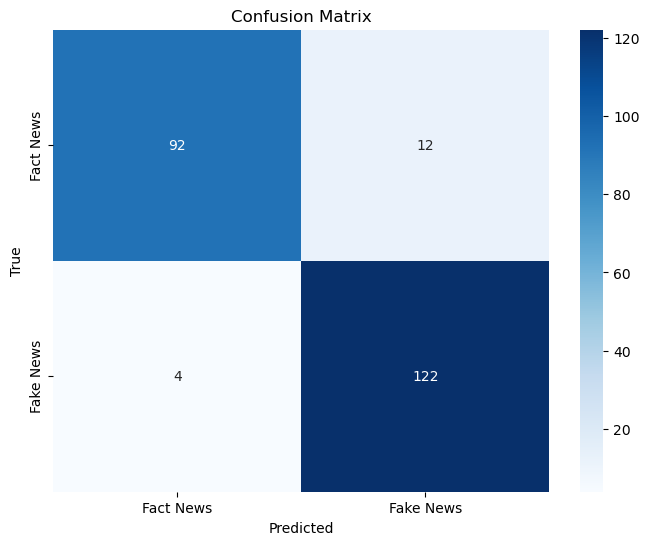

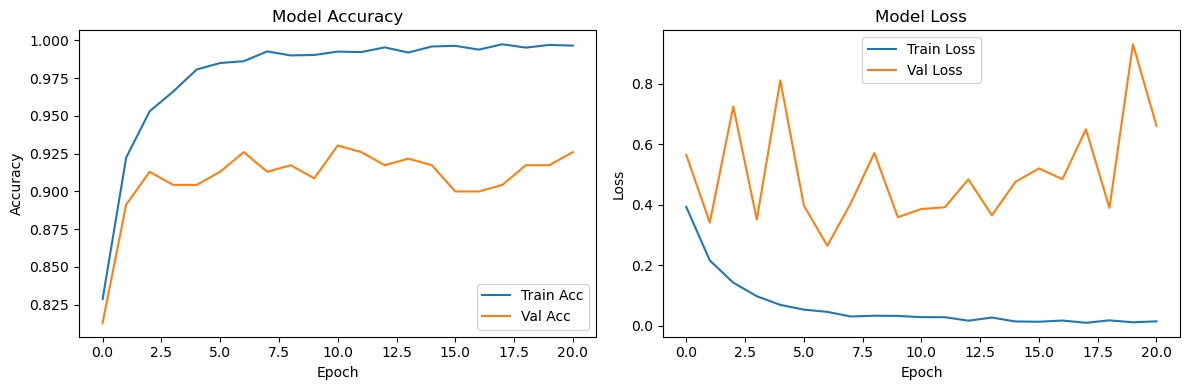

In [7]:
# Train (or re-train) the model
model, tokenizer, history = main_pytorch()


In [10]:
def predict_fake_news(title, content, model, tokenizer, device, maxlen=200):
    """
    Predict whether the provided title and content constitute Fake News or Fact News.
    Returns "Fake News" or "Fact News".
    """
    combined_text = f"{title} {content}"

    # Preprocess the text
    cleaned_text = process_thai_text(combined_text)

    # Tokenize and pad
    sequences = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post')
    input_ids = torch.tensor(padded_sequences, dtype=torch.long).to(device)

    # Extract engineered features
    eng_feats = add_engineered_features(combined_text)
    eng_feats = torch.tensor(eng_feats, dtype=torch.float).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_ids, eng_feats)
        _, preds = torch.max(outputs, 1)
        prediction = preds.item()

    label_map = {0: "Fact News", 1: "Fake News"}
    return label_map.get(prediction, "Unknown")

def test_model(title, content):
    """
    Load tokenizer, model checkpoint, then predict Fake News or Fact News for given input.
    """
    print(f"Using device: {device}")

    # Load the tokenizer
    try:
        with open('tokenizer.pickle', 'rb') as handle:
            tokenizer = pickle.load(handle)
        print("Tokenizer loaded successfully.")
    except FileNotFoundError:
        print("Error: 'tokenizer.pickle' not found.")
        return

    # Load class weights (optional)
    try:
        class_weights = torch.load('class_weights.pth', map_location=device)
        print("Class weights loaded successfully.")
    except FileNotFoundError:
        print("Warning: 'class_weights.pth' not found. Proceeding without class weights.")
        class_weights = None

    # Initialize the model
    vocab_size = len(tokenizer.word_index)
    embedding_dim = 200
    n_eng_features = 4
    model = FakeNewsModel(vocab_size, embedding_dim, n_eng_features).to(device)

    # Load the model checkpoint
    try:
        checkpoint = torch.load('best_model_checkpoint.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print("Model loaded successfully.")
    except FileNotFoundError:
        print("Error: 'best_model_checkpoint.pth' not found.")
        return
    except KeyError:
        print("Error: The checkpoint does not contain 'model_state_dict'.")
        return

    # Make Prediction
    prediction = predict_fake_news(title, content, model, tokenizer, device)
    print(f"Prediction: {prediction}")
    return prediction


In [11]:

title_example = "กสม.ชง ครม.กำหนดเกณฑ์เยียวยาใหม่ หลังบางอาชีพไม่ได้เงินประกันตนช่วงโควิด"
content_example = """เมื่อวันที่ 27 ธ.ค. 2567 นายวสันต์  ภัยหลีกลี้ กรรมการสิทธิมนุษยชนแห่งชาติ เปิดเผยว่า คณะกรรมการสิทธิมนุษยชนแห่งชาติ (กสม.) ..."""

# Prediction
test_model(title_example, content_example)


Using device: cuda
Tokenizer loaded successfully.
Class weights loaded successfully.
Model loaded successfully.
Prediction: Fact News


C:\Users\sirap\AppData\Local\Temp\ipykernel_2460\2929286726.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load('class_weights.pth', map_location

'Fact News'

In [12]:
# Example of testing the provided data in the same notebook

# Sample data
test_data = {
    "Title": [""],
    "Detail": [
        "📌", "📌", "ไม่", "จริง", "อย่า", "แชร์", "!", "ไวรัส", "โคโรนา", "แพร่", "กระจาย", "ผ่าน",
        "อากาศ", "👉", "http://realnewsthailand.net/newsdetail-rnt.php?nid=2511", "👉", "👉", "ตาม",
        "ที่", "มี", "ข่าว", "ปรากฏ", "ใน", "สื่อ", "ต่างๆ", "เกี่ยว", "กับ", "เรื่อง", "ไวรัส", "โคโรนา",
        "แพร่", "กระจาย", "ผ่าน", "อากาศ", "(", "Airborne", ")", "นั้น", "ทาง", "ศูนย์", "ต่อ", "ต้าน",
        "ข่าว", "ปลอม", "ได้", "ดำเนิน", "การ", "ตรวจ", "สอบ", "ข้อ", "เท็จ", "จริง", "กับ", "กรม",
        "ควบคุม", "โรค", "กระทรวง", "สาธารณสุข", "พบ", "ว่า", "ประเด็น", "ดัง", "กล่าว", "นั้น",
        "เป็น", "ข้อมูล", "เท็จ", "🍀", "🍀", "..."
    ]
}

# Convert them into single strings for title and content
title_test = test_data["Title"][0]  # "" (an empty string in this example)
content_test = " ".join(test_data["Detail"])

# Now call the test_model() function from your notebook (must be defined earlier).
test_model(title_test, content_test)


Using device: cuda
Tokenizer loaded successfully.
Class weights loaded successfully.
Model loaded successfully.


C:\Users\sirap\AppData\Local\Temp\ipykernel_2460\2929286726.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load('class_weights.pth', map_location

Prediction: Fact News


'Fact News'

In [13]:
# Sample data
test_data_2 = {
    "Title": ["พบ", "บ่อน้ำ", "ศักดิ์สิทธิ์", "ใต้", "ต้น", "โพธิ์", "สมัย", "ศรีสัชนาลัย", "800", "ปี", "คาด", "ไหล", "ซึม", "จาก", "ราก", "เขา", "นาง", "นอน"],
    "Detail": [
        "26", "ส.ค", ".", "61", "ผู้", "สื่อ", "ข่าว", "รายงาน", "ว่า", "ที่", "บริเวณ", "ทุ่ง", "หญ้า",
        "เลี้ยง", "สัตว์", "กลาง", "เขา", "หมู่", "5", "บ้าน", "แสน", "ตอ", "ต.สาร", "จิตร", "อ.ศรีสัชนาลัย",
        "จ.สุโขทัย", "มี", "บ่อน้ำ", "เก่า", "แก่", "ยุค", "เมือง", "โบราณ", "ศรีสัชนาลัย", "ชาว", "บ้าน",
        "ร่ำ", "ลือ", "ว่า", "น้ำ", "ใน", "บ่อ", "นี้", "ไม่", "เคย", "แห้ง", "แม้", "จะ", "เจอ", "สภาพ",
        "อากาศ", "ที่", "แล้ง", "จัด", "เพียง", "ใด", "ก็ตาม", "ขณะ", "ที่", "บาง", "คน", "เชื่อ", "ว่า",
        "เป็น", "น้ำ", "ศักดิ์สิทธิ์", "กิน", "แล้ว", "รักษา", "โรค", "เจ็บ", "ป่วย", "ให้", "หาย",
        "ได้", "ด้วย", "..."
    ]
}

# Convert tokens to strings
title_test_2 = " ".join(test_data_2["Title"])
content_test_2 = " ".join(test_data_2["Detail"])

# Call the test_model function (must be defined in the same notebook)
test_model(title_test_2, content_test_2)


Using device: cuda
Tokenizer loaded successfully.
Class weights loaded successfully.
Model loaded successfully.


C:\Users\sirap\AppData\Local\Temp\ipykernel_2460\2929286726.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load('class_weights.pth', map_location

Prediction: Fake News


'Fake News'